In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/deepfake_tweets"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
MODEL_EXPORT_DIR = ABSOLUTE_PATH + "/models/bert"

Mounted at /content/drive


In [17]:
import sys
sys.path.insert(0, ABSOLUTE_PATH)

# Training BERT Transformer

In [18]:
!pip install transformers --upgrade

In [31]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torch.optim import AdamW
from tqdm import tqdm
from utils import TweetDataset, train_model, export_model, evaluate_model


# MODEL CONSTANTS
MODEL_NAME = "bert-base-cased"
NUM_LABELS = 2
BATCH_SIZE = 32
EPOCHS = 4

## Loading (preprocessed) tweepfake dataset

In [20]:
# Import splits of the dataset (train, val, test)
train_set_path, val_set_path, test_set_path = (
    os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_train.csv"),
    os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_val.csv"),
    os.path.join(PREPROCESSED_DATA_DIR, "tweepfake_test.csv")
)

train_df, val_df, test_df = (
    pd.read_csv(train_set_path),
    pd.read_csv(val_set_path),
    pd.read_csv(test_set_path)
)

# Concatenate split sets into a single DataFrame
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

## Prepare datasets for binary classification

In [21]:
# Using text_tokens column for better preprocessing if available
text_column = 'text_tokens' if 'text_tokens' in train_df.columns else 'text'

X_train = train_df[text_column].values
y_train = (train_df['account.type'] == 'bot').astype(int).values

X_val = val_df[text_column].values
y_val = (val_df['account.type'] == 'bot').astype(int).values

X_test = test_df[text_column].values
y_test = (test_df['account.type'] == 'bot').astype(int).values

## Load BERT model and tokenizer

In [22]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    output_attentions=False,
    output_hidden_states=False
)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Create PyTorch datasets and dataloaders

In [23]:
train_dataset = TweetDataset(X_train, y_train, tokenizer)
val_dataset = TweetDataset(X_val, y_val, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Training BERT

In [24]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Fine-tuning the model

In [25]:
finetuned_model, training_stats = train_model(
    model, train_dataloader, val_dataloader, optimizer, scheduler, epochs, device)


======== Epoch 1 / 4 ========
Training...


Training: 100%|██████████| 648/648 [06:56<00:00,  1.56it/s, loss=0.5191]


Average training loss: 0.3714
Running validation...


Validation: 100%|██████████| 72/72 [00:15<00:00,  4.56it/s]


Validation Loss: 0.3436
Validation Accuracy: 0.8427
Validation F1 Score: 0.8525
New best model with validation accuracy: 0.8427

======== Epoch 2 / 4 ========
Training...


Training: 100%|██████████| 648/648 [07:01<00:00,  1.54it/s, loss=0.5056]


Average training loss: 0.2896
Running validation...


Validation: 100%|██████████| 72/72 [00:15<00:00,  4.59it/s]


Validation Loss: 0.3363
Validation Accuracy: 0.8475
Validation F1 Score: 0.8513
New best model with validation accuracy: 0.8475

======== Epoch 3 / 4 ========
Training...


Training: 100%|██████████| 648/648 [07:00<00:00,  1.54it/s, loss=0.1814]


Average training loss: 0.2053
Running validation...


Validation: 100%|██████████| 72/72 [00:15<00:00,  4.56it/s]


Validation Loss: 0.3748
Validation Accuracy: 0.8519
Validation F1 Score: 0.8538
New best model with validation accuracy: 0.8519

======== Epoch 4 / 4 ========
Training...


Training: 100%|██████████| 648/648 [07:00<00:00,  1.54it/s, loss=0.0118]


Average training loss: 0.1396
Running validation...


Validation: 100%|██████████| 72/72 [00:15<00:00,  4.56it/s]

Validation Loss: 0.4670
Validation Accuracy: 0.8458
Validation F1 Score: 0.8463
Loaded best model with validation accuracy: 0.8519


#### Plot training and validation loss

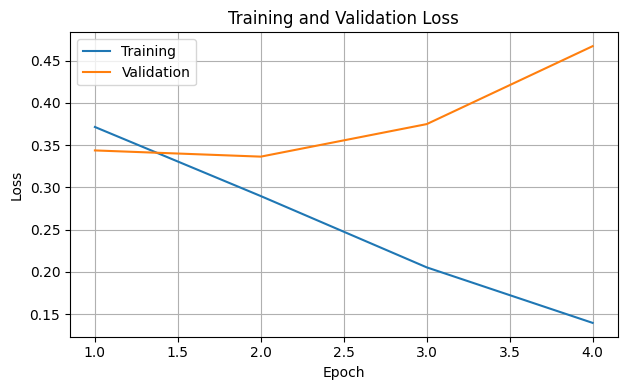

In [26]:
stats_df = pd.DataFrame(training_stats)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(stats_df['epoch'], stats_df['train_loss'], label='Training')
plt.plot(stats_df['epoch'], stats_df['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

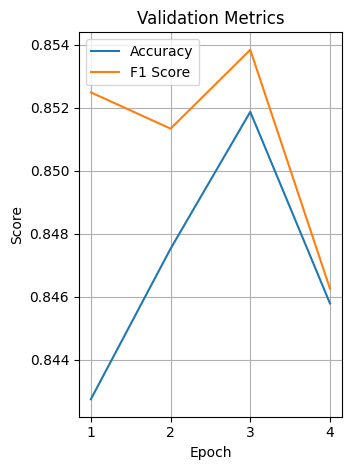

In [27]:
plt.subplot(1, 2, 2)
plt.plot(stats_df['epoch'], stats_df['val_accuracy'], label='Accuracy')
plt.plot(stats_df['epoch'], stats_df['val_f1'], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation on the test set

In [33]:
eval_results = evaluate_model(finetuned_model, test_dataloader, device)

Evaluating: 100%|██████████| 80/80 [00:17<00:00,  4.57it/s]


In [34]:
print(f"Test Loss: {eval_results['loss']:.4f}")
print(f"Test Accuracy: {eval_results['accuracy']:.4f}")
print(f"Test F1 Score: {eval_results['f1']:.4f}")\

print("\nClassification Report:")
print(classification_report(
        eval_results['true_labels'], eval_results['predictions'], target_names=['Human', 'Bot']))

Test Loss: 0.4981
Test Accuracy: 0.8405
Test F1 Score: 0.8417

Classification Report:
              precision    recall  f1-score   support

       Human       0.85      0.83      0.84      1278
         Bot       0.84      0.85      0.84      1280

    accuracy                           0.84      2558
   macro avg       0.84      0.84      0.84      2558
weighted avg       0.84      0.84      0.84      2558



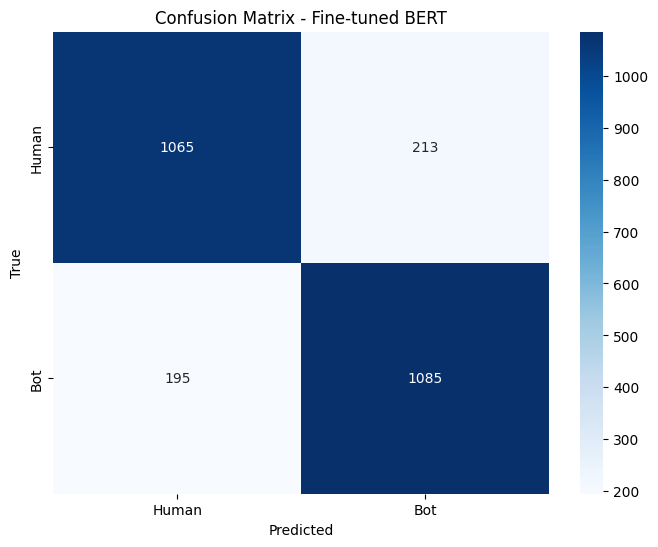

In [35]:
cm = confusion_matrix(eval_results['true_labels'], eval_results['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fine-tuned BERT')
plt.show()

## Export fine-tuned BERT model

In [36]:
export_model(finetuned_model, tokenizer, MODEL_EXPORT_DIR)